# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

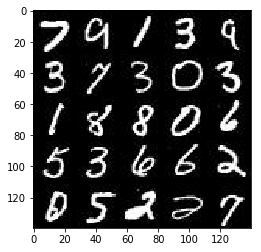

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

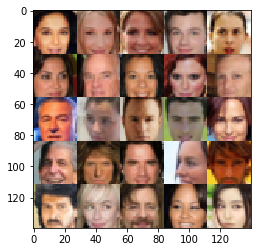

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)        
        relu1 = tf.nn.dropout(relu1, 0.5)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, 0.5)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.5)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)       

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        # print('x1: ', x1.get_shape())
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        # print('x2: ', x2.get_shape())
        # 14x14x128 now

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        # print('x3: ', x3.get_shape())
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # print('logits: ', logits.get_shape())
        # 28x28x? now
        
        out = tf.tanh(logits)
        # print('out: ', out.get_shape())
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    print('data_shape: %s' % (data_shape,))
    input_real, input_z, _ = model_inputs(image_width=data_shape[1], image_height=data_shape[2], image_channels=data_shape[3], z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print('input_z shape: ', input_z.get_shape().as_list()[-1])
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                # Perform a second optimization run for the generator
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape: (60000, 28, 28, 1)
input_z shape:  100
Step 10... Discriminator Loss: 2.6313... Generator Loss: 0.5568
Step 20... Discriminator Loss: 3.8543... Generator Loss: 0.1517
Step 30... Discriminator Loss: 1.7823... Generator Loss: 1.5220
Step 40... Discriminator Loss: 1.7738... Generator Loss: 1.3104
Step 50... Discriminator Loss: 0.5349... Generator Loss: 2.1721
Step 60... Discriminator Loss: 0.0794... Generator Loss: 4.4042
Step 70... Discriminator Loss: 0.0044... Generator Loss: 8.2109
Step 80... Discriminator Loss: 2.8466... Generator Loss: 0.2311
Step 90... Discriminator Loss: 0.3332... Generator Loss: 3.4718
Step 100... Discriminator Loss: 0.2503... Generator Loss: 3.6274


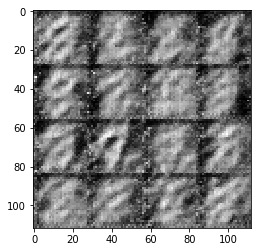

Step 110... Discriminator Loss: 0.5919... Generator Loss: 2.9661
Step 120... Discriminator Loss: 4.2346... Generator Loss: 6.1022
Step 130... Discriminator Loss: 1.1254... Generator Loss: 1.4717
Step 140... Discriminator Loss: 1.2395... Generator Loss: 0.8231
Step 150... Discriminator Loss: 1.6175... Generator Loss: 0.9855
Step 160... Discriminator Loss: 1.5878... Generator Loss: 0.6404
Step 170... Discriminator Loss: 1.1218... Generator Loss: 1.0257
Step 180... Discriminator Loss: 1.1647... Generator Loss: 1.7076
Step 190... Discriminator Loss: 1.0087... Generator Loss: 0.7852
Step 200... Discriminator Loss: 0.9356... Generator Loss: 1.3803


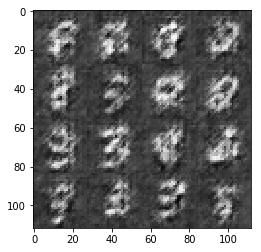

Step 210... Discriminator Loss: 1.0421... Generator Loss: 1.0979
Step 220... Discriminator Loss: 1.2225... Generator Loss: 0.7000
Step 230... Discriminator Loss: 0.9387... Generator Loss: 1.3628
Step 240... Discriminator Loss: 1.1275... Generator Loss: 1.9461
Step 250... Discriminator Loss: 1.0490... Generator Loss: 1.3425
Step 260... Discriminator Loss: 0.3893... Generator Loss: 2.1159
Step 270... Discriminator Loss: 1.3654... Generator Loss: 1.2397
Step 280... Discriminator Loss: 1.0276... Generator Loss: 1.3950
Step 290... Discriminator Loss: 0.8524... Generator Loss: 1.8544
Step 300... Discriminator Loss: 0.8042... Generator Loss: 1.7667


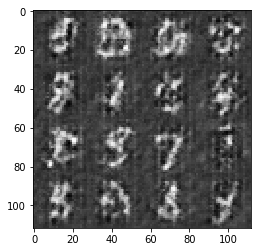

Step 310... Discriminator Loss: 0.8459... Generator Loss: 1.7706
Step 320... Discriminator Loss: 0.6642... Generator Loss: 3.0381
Step 330... Discriminator Loss: 0.5948... Generator Loss: 1.6357
Step 340... Discriminator Loss: 2.1586... Generator Loss: 0.3361
Step 350... Discriminator Loss: 0.8408... Generator Loss: 1.5374
Step 360... Discriminator Loss: 1.2521... Generator Loss: 0.7695
Step 370... Discriminator Loss: 1.4209... Generator Loss: 0.5085
Step 380... Discriminator Loss: 1.0176... Generator Loss: 1.6246
Step 390... Discriminator Loss: 0.5910... Generator Loss: 2.5583
Step 400... Discriminator Loss: 0.6529... Generator Loss: 1.1770


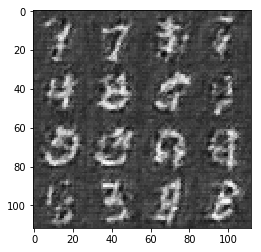

Step 410... Discriminator Loss: 0.8184... Generator Loss: 1.2015
Step 420... Discriminator Loss: 0.6033... Generator Loss: 1.9898
Step 430... Discriminator Loss: 1.0730... Generator Loss: 2.6768
Step 440... Discriminator Loss: 1.1197... Generator Loss: 1.8593
Step 450... Discriminator Loss: 1.0740... Generator Loss: 0.9198
Step 460... Discriminator Loss: 0.7193... Generator Loss: 1.2680
Step 470... Discriminator Loss: 0.7493... Generator Loss: 1.2429
Step 480... Discriminator Loss: 0.4996... Generator Loss: 1.8447
Step 490... Discriminator Loss: 0.7792... Generator Loss: 2.3953
Step 500... Discriminator Loss: 0.6706... Generator Loss: 2.3166


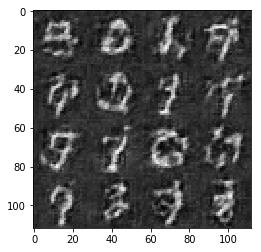

Step 510... Discriminator Loss: 0.3796... Generator Loss: 2.1297
Step 520... Discriminator Loss: 0.4092... Generator Loss: 2.2378
Step 530... Discriminator Loss: 0.5931... Generator Loss: 1.1464
Step 540... Discriminator Loss: 1.1298... Generator Loss: 0.7478
Step 550... Discriminator Loss: 0.2915... Generator Loss: 3.1274
Step 560... Discriminator Loss: 0.6375... Generator Loss: 2.4232
Step 570... Discriminator Loss: 0.5034... Generator Loss: 1.6018
Step 580... Discriminator Loss: 0.4347... Generator Loss: 3.2822
Step 590... Discriminator Loss: 0.8183... Generator Loss: 2.2746
Step 600... Discriminator Loss: 0.5007... Generator Loss: 2.0309


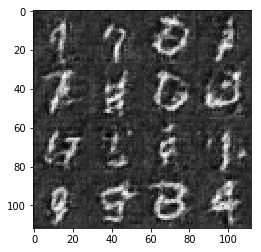

Step 610... Discriminator Loss: 0.5222... Generator Loss: 1.7571
Step 620... Discriminator Loss: 0.6768... Generator Loss: 3.3963
Step 630... Discriminator Loss: 0.4551... Generator Loss: 1.8254
Step 640... Discriminator Loss: 0.4716... Generator Loss: 2.1106
Step 650... Discriminator Loss: 0.2985... Generator Loss: 2.9561
Step 660... Discriminator Loss: 0.3515... Generator Loss: 2.6626
Step 670... Discriminator Loss: 2.1922... Generator Loss: 5.3985
Step 680... Discriminator Loss: 0.6124... Generator Loss: 2.8944
Step 690... Discriminator Loss: 0.7425... Generator Loss: 1.4779
Step 700... Discriminator Loss: 0.4191... Generator Loss: 2.4757


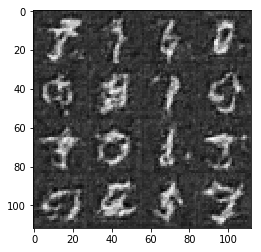

Step 710... Discriminator Loss: 0.5376... Generator Loss: 1.4429
Step 720... Discriminator Loss: 0.4508... Generator Loss: 6.0084
Step 730... Discriminator Loss: 0.3309... Generator Loss: 1.6182
Step 740... Discriminator Loss: 0.7242... Generator Loss: 2.0951
Step 750... Discriminator Loss: 0.6173... Generator Loss: 2.3001
Step 760... Discriminator Loss: 0.5866... Generator Loss: 1.9097
Step 770... Discriminator Loss: 0.2891... Generator Loss: 3.2789
Step 780... Discriminator Loss: 0.2801... Generator Loss: 3.3392
Step 790... Discriminator Loss: 0.3277... Generator Loss: 2.1823
Step 800... Discriminator Loss: 0.4345... Generator Loss: 4.0797


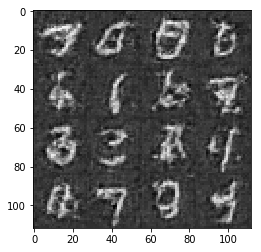

Step 810... Discriminator Loss: 0.5197... Generator Loss: 2.0076
Step 820... Discriminator Loss: 0.6953... Generator Loss: 1.8615
Step 830... Discriminator Loss: 0.3684... Generator Loss: 3.0062
Step 840... Discriminator Loss: 0.2521... Generator Loss: 3.0841
Step 850... Discriminator Loss: 0.3148... Generator Loss: 1.9484
Step 860... Discriminator Loss: 0.2596... Generator Loss: 2.0807
Step 870... Discriminator Loss: 0.2333... Generator Loss: 3.6010
Step 880... Discriminator Loss: 0.2412... Generator Loss: 2.7700
Step 890... Discriminator Loss: 1.3439... Generator Loss: 0.5499
Step 900... Discriminator Loss: 0.5934... Generator Loss: 1.8094


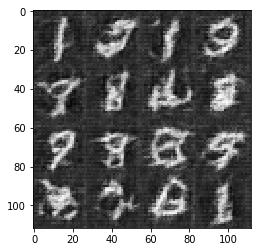

Step 910... Discriminator Loss: 0.7619... Generator Loss: 1.4176
Step 920... Discriminator Loss: 0.3536... Generator Loss: 1.9135
Step 930... Discriminator Loss: 0.3810... Generator Loss: 3.5729
Step 940... Discriminator Loss: 0.4015... Generator Loss: 3.8829
Step 950... Discriminator Loss: 0.4297... Generator Loss: 2.0906
Step 960... Discriminator Loss: 0.3812... Generator Loss: 1.9713
Step 970... Discriminator Loss: 0.1822... Generator Loss: 3.9226
Step 980... Discriminator Loss: 0.3122... Generator Loss: 1.9960
Step 990... Discriminator Loss: 0.3206... Generator Loss: 3.4321
Step 1000... Discriminator Loss: 0.4830... Generator Loss: 2.1719


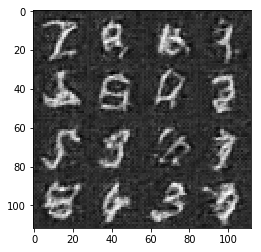

Step 1010... Discriminator Loss: 0.5231... Generator Loss: 2.2834
Step 1020... Discriminator Loss: 0.1220... Generator Loss: 2.6192
Step 1030... Discriminator Loss: 3.2476... Generator Loss: 0.1645
Step 1040... Discriminator Loss: 1.1388... Generator Loss: 2.0345
Step 1050... Discriminator Loss: 0.4609... Generator Loss: 2.6508
Step 1060... Discriminator Loss: 0.3717... Generator Loss: 2.3879
Step 1070... Discriminator Loss: 0.3113... Generator Loss: 3.5901
Step 1080... Discriminator Loss: 0.1653... Generator Loss: 4.1581
Step 1090... Discriminator Loss: 0.1973... Generator Loss: 3.7467
Step 1100... Discriminator Loss: 0.1604... Generator Loss: 3.3852


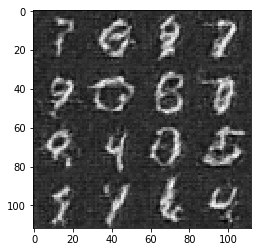

Step 1110... Discriminator Loss: 0.1268... Generator Loss: 3.6159
Step 1120... Discriminator Loss: 0.5461... Generator Loss: 2.7861
Step 1130... Discriminator Loss: 0.1867... Generator Loss: 2.4251
Step 1140... Discriminator Loss: 0.1897... Generator Loss: 3.7364
Step 1150... Discriminator Loss: 0.1870... Generator Loss: 2.9816
Step 1160... Discriminator Loss: 0.3636... Generator Loss: 2.2604
Step 1170... Discriminator Loss: 0.0973... Generator Loss: 4.3486
Step 1180... Discriminator Loss: 0.1459... Generator Loss: 3.3206
Step 1190... Discriminator Loss: 0.1534... Generator Loss: 4.9047
Step 1200... Discriminator Loss: 0.0880... Generator Loss: 3.6240


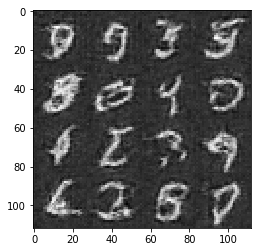

Step 1210... Discriminator Loss: 0.0886... Generator Loss: 5.5990
Step 1220... Discriminator Loss: 0.1062... Generator Loss: 4.7483
Step 1230... Discriminator Loss: 0.7412... Generator Loss: 1.5662
Step 1240... Discriminator Loss: 0.1029... Generator Loss: 4.2947
Step 1250... Discriminator Loss: 0.1085... Generator Loss: 3.9661
Step 1260... Discriminator Loss: 0.9651... Generator Loss: 1.1976
Step 1270... Discriminator Loss: 1.3658... Generator Loss: 0.7127
Step 1280... Discriminator Loss: 0.7290... Generator Loss: 3.4710
Step 1290... Discriminator Loss: 1.3969... Generator Loss: 0.7114
Step 1300... Discriminator Loss: 0.6077... Generator Loss: 1.9126


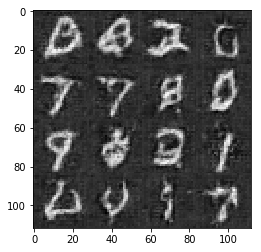

Step 1310... Discriminator Loss: 0.6504... Generator Loss: 3.4831
Step 1320... Discriminator Loss: 0.3106... Generator Loss: 2.7449
Step 1330... Discriminator Loss: 0.4126... Generator Loss: 1.9683
Step 1340... Discriminator Loss: 0.3420... Generator Loss: 2.3009
Step 1350... Discriminator Loss: 0.3736... Generator Loss: 2.8581
Step 1360... Discriminator Loss: 0.3004... Generator Loss: 4.2801
Step 1370... Discriminator Loss: 0.2909... Generator Loss: 3.6746
Step 1380... Discriminator Loss: 0.1534... Generator Loss: 3.1619
Step 1390... Discriminator Loss: 0.2513... Generator Loss: 3.7397
Step 1400... Discriminator Loss: 0.3827... Generator Loss: 2.1399


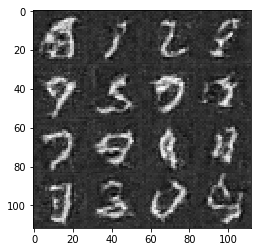

Step 1410... Discriminator Loss: 0.0932... Generator Loss: 4.7380
Step 1420... Discriminator Loss: 0.6415... Generator Loss: 6.7904
Step 1430... Discriminator Loss: 0.4872... Generator Loss: 2.4627
Step 1440... Discriminator Loss: 0.6241... Generator Loss: 2.6049
Step 1450... Discriminator Loss: 0.6356... Generator Loss: 2.0555
Step 1460... Discriminator Loss: 0.3676... Generator Loss: 3.1320
Step 1470... Discriminator Loss: 0.2612... Generator Loss: 3.6997
Step 1480... Discriminator Loss: 0.1703... Generator Loss: 2.9094
Step 1490... Discriminator Loss: 0.3052... Generator Loss: 2.6155
Step 1500... Discriminator Loss: 0.1491... Generator Loss: 3.7780


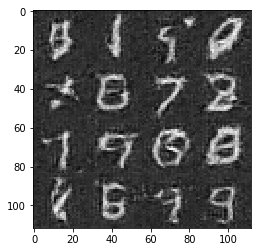

Step 1510... Discriminator Loss: 0.2366... Generator Loss: 3.4579
Step 1520... Discriminator Loss: 0.1894... Generator Loss: 3.7354
Step 1530... Discriminator Loss: 0.2096... Generator Loss: 4.9302
Step 1540... Discriminator Loss: 0.2756... Generator Loss: 2.4099
Step 1550... Discriminator Loss: 0.1075... Generator Loss: 3.2354
Step 1560... Discriminator Loss: 0.1415... Generator Loss: 5.2305
Step 1570... Discriminator Loss: 0.2323... Generator Loss: 4.6830
Step 1580... Discriminator Loss: 0.0664... Generator Loss: 4.8344
Step 1590... Discriminator Loss: 0.1807... Generator Loss: 3.3171
Step 1600... Discriminator Loss: 0.1042... Generator Loss: 2.6997


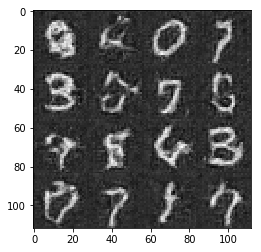

Step 1610... Discriminator Loss: 0.0711... Generator Loss: 4.0924
Step 1620... Discriminator Loss: 0.2442... Generator Loss: 4.8348
Step 1630... Discriminator Loss: 0.0538... Generator Loss: 4.7817
Step 1640... Discriminator Loss: 0.0828... Generator Loss: 4.6493
Step 1650... Discriminator Loss: 0.1137... Generator Loss: 5.5578
Step 1660... Discriminator Loss: 0.0636... Generator Loss: 4.6921
Step 1670... Discriminator Loss: 0.0474... Generator Loss: 4.9923
Step 1680... Discriminator Loss: 0.2114... Generator Loss: 6.5439
Step 1690... Discriminator Loss: 0.0256... Generator Loss: 4.1782
Step 1700... Discriminator Loss: 0.0572... Generator Loss: 4.9639


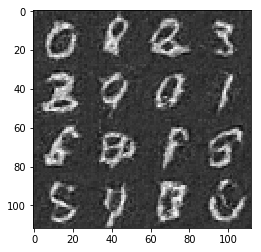

Step 1710... Discriminator Loss: 0.0679... Generator Loss: 4.7680
Step 1720... Discriminator Loss: 0.0957... Generator Loss: 2.7816
Step 1730... Discriminator Loss: 2.5942... Generator Loss: 3.2796
Step 1740... Discriminator Loss: 0.7562... Generator Loss: 2.1830
Step 1750... Discriminator Loss: 0.9923... Generator Loss: 1.3195
Step 1760... Discriminator Loss: 0.5119... Generator Loss: 2.3819
Step 1770... Discriminator Loss: 0.6238... Generator Loss: 3.4906
Step 1780... Discriminator Loss: 0.2720... Generator Loss: 3.3769
Step 1790... Discriminator Loss: 0.4204... Generator Loss: 4.7156
Step 1800... Discriminator Loss: 0.6040... Generator Loss: 3.8637


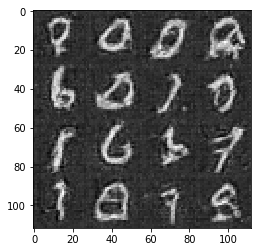

Step 1810... Discriminator Loss: 0.3481... Generator Loss: 2.8680
Step 1820... Discriminator Loss: 0.1933... Generator Loss: 2.4650
Step 1830... Discriminator Loss: 0.3454... Generator Loss: 1.4461
Step 1840... Discriminator Loss: 0.2116... Generator Loss: 3.2955
Step 1850... Discriminator Loss: 0.3923... Generator Loss: 4.9579
Step 1860... Discriminator Loss: 0.1948... Generator Loss: 5.2068
Step 1870... Discriminator Loss: 0.1542... Generator Loss: 3.8459


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.001 #0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape: (202599, 28, 28, 3)
input_z shape:  100
Step 10... Discriminator Loss: 1.5275... Generator Loss: 0.9362
Step 20... Discriminator Loss: 1.4923... Generator Loss: 1.4008
Step 30... Discriminator Loss: 2.1219... Generator Loss: 4.6666
Step 40... Discriminator Loss: 0.3402... Generator Loss: 2.9011
Step 50... Discriminator Loss: 0.0726... Generator Loss: 5.7948
Step 60... Discriminator Loss: 0.0566... Generator Loss: 4.5089
Step 70... Discriminator Loss: 0.0634... Generator Loss: 4.8981
Step 80... Discriminator Loss: 1.4204... Generator Loss: 0.9089
Step 90... Discriminator Loss: 0.4825... Generator Loss: 1.9136
Step 100... Discriminator Loss: 0.4694... Generator Loss: 1.5836


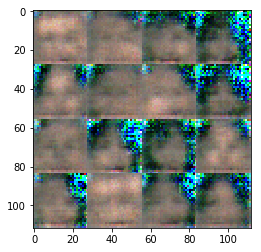

Step 110... Discriminator Loss: 0.1494... Generator Loss: 2.6875
Step 120... Discriminator Loss: 0.1490... Generator Loss: 2.5106
Step 130... Discriminator Loss: 1.4899... Generator Loss: 0.6422
Step 140... Discriminator Loss: 0.3254... Generator Loss: 2.3701
Step 150... Discriminator Loss: 0.0983... Generator Loss: 3.8047
Step 160... Discriminator Loss: 0.1779... Generator Loss: 2.8364
Step 170... Discriminator Loss: 0.2400... Generator Loss: 2.4694
Step 180... Discriminator Loss: 7.5056... Generator Loss: 6.8121
Step 190... Discriminator Loss: 0.6589... Generator Loss: 1.7138
Step 200... Discriminator Loss: 3.3673... Generator Loss: 4.2614


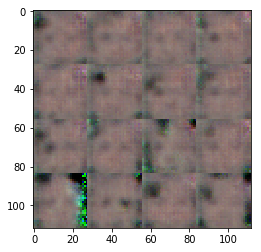

Step 210... Discriminator Loss: 0.9151... Generator Loss: 1.0118
Step 220... Discriminator Loss: 1.0053... Generator Loss: 1.1413
Step 230... Discriminator Loss: 1.1049... Generator Loss: 0.5095
Step 240... Discriminator Loss: 1.5064... Generator Loss: 1.4355
Step 250... Discriminator Loss: 1.4992... Generator Loss: 0.7570
Step 260... Discriminator Loss: 1.1010... Generator Loss: 0.7787
Step 270... Discriminator Loss: 1.3235... Generator Loss: 0.7359
Step 280... Discriminator Loss: 1.2866... Generator Loss: 0.5567
Step 290... Discriminator Loss: 1.2561... Generator Loss: 1.0616
Step 300... Discriminator Loss: 1.3777... Generator Loss: 0.8730


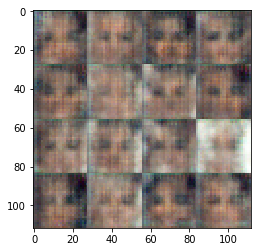

Step 310... Discriminator Loss: 1.4820... Generator Loss: 0.9529
Step 320... Discriminator Loss: 1.5528... Generator Loss: 0.8543
Step 330... Discriminator Loss: 1.3895... Generator Loss: 0.6667
Step 340... Discriminator Loss: 1.4577... Generator Loss: 0.8143
Step 350... Discriminator Loss: 1.4520... Generator Loss: 1.0674
Step 360... Discriminator Loss: 1.4310... Generator Loss: 0.8531
Step 370... Discriminator Loss: 1.3797... Generator Loss: 0.9408
Step 380... Discriminator Loss: 1.3046... Generator Loss: 0.7516
Step 390... Discriminator Loss: 1.3648... Generator Loss: 0.7981
Step 400... Discriminator Loss: 1.5587... Generator Loss: 0.6944


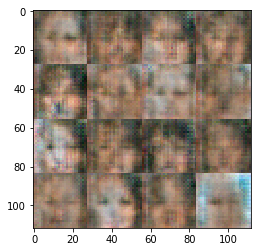

Step 410... Discriminator Loss: 1.3556... Generator Loss: 0.7152
Step 420... Discriminator Loss: 1.4012... Generator Loss: 0.5626
Step 430... Discriminator Loss: 1.4384... Generator Loss: 0.7686
Step 440... Discriminator Loss: 1.5526... Generator Loss: 0.9596
Step 450... Discriminator Loss: 1.2128... Generator Loss: 1.3202
Step 460... Discriminator Loss: 1.4556... Generator Loss: 0.6741
Step 470... Discriminator Loss: 1.2303... Generator Loss: 0.6786
Step 480... Discriminator Loss: 1.4277... Generator Loss: 0.8325
Step 490... Discriminator Loss: 1.3668... Generator Loss: 0.8688
Step 500... Discriminator Loss: 1.3886... Generator Loss: 0.7455


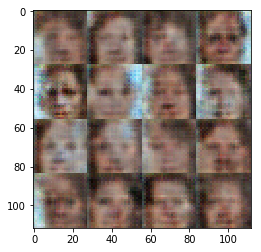

Step 510... Discriminator Loss: 1.2758... Generator Loss: 0.9103
Step 520... Discriminator Loss: 1.2636... Generator Loss: 0.6777
Step 530... Discriminator Loss: 1.6525... Generator Loss: 0.7753
Step 540... Discriminator Loss: 1.4690... Generator Loss: 1.1161
Step 550... Discriminator Loss: 1.2274... Generator Loss: 1.2834
Step 560... Discriminator Loss: 1.3787... Generator Loss: 0.5609
Step 570... Discriminator Loss: 1.7022... Generator Loss: 1.0491
Step 580... Discriminator Loss: 1.7292... Generator Loss: 0.6155
Step 590... Discriminator Loss: 1.0648... Generator Loss: 0.8844
Step 600... Discriminator Loss: 1.4445... Generator Loss: 0.6906


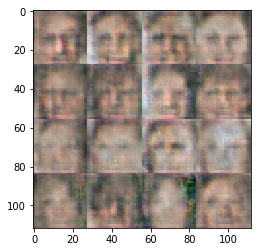

Step 610... Discriminator Loss: 1.4445... Generator Loss: 0.7937
Step 620... Discriminator Loss: 1.4659... Generator Loss: 0.7363
Step 630... Discriminator Loss: 1.5948... Generator Loss: 0.6024
Step 640... Discriminator Loss: 1.4513... Generator Loss: 0.7814
Step 650... Discriminator Loss: 1.4778... Generator Loss: 0.8065
Step 660... Discriminator Loss: 1.3269... Generator Loss: 0.8129
Step 670... Discriminator Loss: 1.5438... Generator Loss: 0.4202
Step 680... Discriminator Loss: 1.2436... Generator Loss: 0.6831
Step 690... Discriminator Loss: 1.3758... Generator Loss: 0.5792
Step 700... Discriminator Loss: 1.2551... Generator Loss: 0.7881


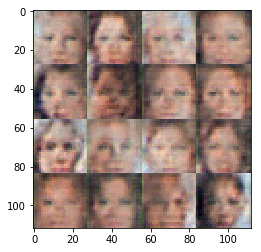

Step 710... Discriminator Loss: 1.4140... Generator Loss: 0.7335
Step 720... Discriminator Loss: 1.4322... Generator Loss: 0.9882
Step 730... Discriminator Loss: 1.4631... Generator Loss: 0.5985
Step 740... Discriminator Loss: 1.2538... Generator Loss: 0.5859
Step 750... Discriminator Loss: 1.6163... Generator Loss: 0.6272
Step 760... Discriminator Loss: 1.3272... Generator Loss: 1.0156
Step 770... Discriminator Loss: 1.3254... Generator Loss: 0.5649
Step 780... Discriminator Loss: 1.4058... Generator Loss: 0.8573
Step 790... Discriminator Loss: 1.6299... Generator Loss: 0.5602
Step 800... Discriminator Loss: 1.4051... Generator Loss: 0.6334


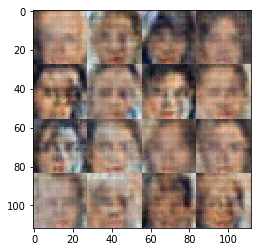

Step 810... Discriminator Loss: 1.5105... Generator Loss: 0.5785
Step 820... Discriminator Loss: 1.4146... Generator Loss: 0.8047
Step 830... Discriminator Loss: 1.2888... Generator Loss: 0.8176
Step 840... Discriminator Loss: 1.4041... Generator Loss: 0.7246
Step 850... Discriminator Loss: 1.5199... Generator Loss: 0.3701
Step 860... Discriminator Loss: 1.5029... Generator Loss: 0.7111
Step 870... Discriminator Loss: 1.3212... Generator Loss: 0.8156
Step 880... Discriminator Loss: 1.4754... Generator Loss: 0.7505
Step 890... Discriminator Loss: 1.3513... Generator Loss: 0.8410
Step 900... Discriminator Loss: 1.2486... Generator Loss: 1.0481


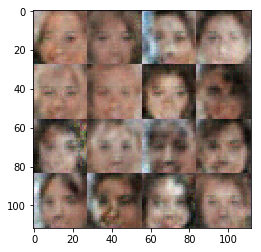

Step 910... Discriminator Loss: 1.5173... Generator Loss: 0.7629
Step 920... Discriminator Loss: 1.3313... Generator Loss: 0.8521
Step 930... Discriminator Loss: 1.4292... Generator Loss: 0.4957
Step 940... Discriminator Loss: 1.1076... Generator Loss: 0.7154
Step 950... Discriminator Loss: 1.4166... Generator Loss: 0.9792
Step 960... Discriminator Loss: 1.6128... Generator Loss: 0.5315
Step 970... Discriminator Loss: 1.3151... Generator Loss: 0.7684
Step 980... Discriminator Loss: 1.4111... Generator Loss: 0.7045
Step 990... Discriminator Loss: 1.3456... Generator Loss: 0.6975
Step 1000... Discriminator Loss: 1.3370... Generator Loss: 0.8472


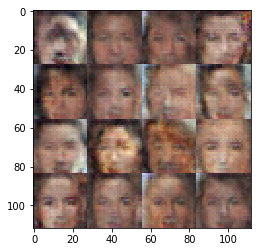

Step 1010... Discriminator Loss: 1.2491... Generator Loss: 0.7466
Step 1020... Discriminator Loss: 1.4305... Generator Loss: 0.9258
Step 1030... Discriminator Loss: 1.3701... Generator Loss: 0.8186
Step 1040... Discriminator Loss: 1.3985... Generator Loss: 0.5499
Step 1050... Discriminator Loss: 1.4327... Generator Loss: 0.7135
Step 1060... Discriminator Loss: 1.4235... Generator Loss: 0.5535
Step 1070... Discriminator Loss: 1.2798... Generator Loss: 0.7423
Step 1080... Discriminator Loss: 1.4820... Generator Loss: 0.5741
Step 1090... Discriminator Loss: 1.3647... Generator Loss: 0.5147
Step 1100... Discriminator Loss: 1.2490... Generator Loss: 0.8220


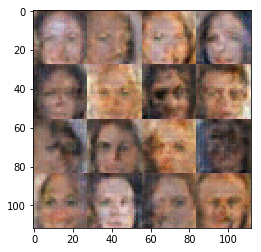

Step 1110... Discriminator Loss: 1.2482... Generator Loss: 0.5299
Step 1120... Discriminator Loss: 1.4648... Generator Loss: 1.0553
Step 1130... Discriminator Loss: 1.3313... Generator Loss: 0.8122
Step 1140... Discriminator Loss: 1.4981... Generator Loss: 0.5276
Step 1150... Discriminator Loss: 1.3120... Generator Loss: 0.6796
Step 1160... Discriminator Loss: 1.2988... Generator Loss: 0.7134
Step 1170... Discriminator Loss: 1.4855... Generator Loss: 0.7314
Step 1180... Discriminator Loss: 1.4021... Generator Loss: 0.8978
Step 1190... Discriminator Loss: 1.4076... Generator Loss: 0.6095
Step 1200... Discriminator Loss: 1.3337... Generator Loss: 0.8856


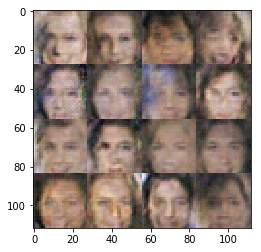

Step 1210... Discriminator Loss: 1.3846... Generator Loss: 0.5044
Step 1220... Discriminator Loss: 1.3855... Generator Loss: 0.9831
Step 1230... Discriminator Loss: 1.4139... Generator Loss: 0.7764
Step 1240... Discriminator Loss: 1.5071... Generator Loss: 0.7241
Step 1250... Discriminator Loss: 1.3939... Generator Loss: 1.0351
Step 1260... Discriminator Loss: 1.3719... Generator Loss: 0.8805
Step 1270... Discriminator Loss: 1.4072... Generator Loss: 0.7483
Step 1280... Discriminator Loss: 1.3936... Generator Loss: 0.5832
Step 1290... Discriminator Loss: 1.3909... Generator Loss: 0.7179
Step 1300... Discriminator Loss: 1.4345... Generator Loss: 0.5387


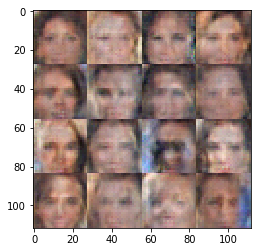

Step 1310... Discriminator Loss: 1.5112... Generator Loss: 0.8550
Step 1320... Discriminator Loss: 1.5048... Generator Loss: 0.9817
Step 1330... Discriminator Loss: 1.3346... Generator Loss: 0.8284
Step 1340... Discriminator Loss: 1.4262... Generator Loss: 0.6437
Step 1350... Discriminator Loss: 1.3359... Generator Loss: 0.7048
Step 1360... Discriminator Loss: 1.3523... Generator Loss: 0.8742
Step 1370... Discriminator Loss: 1.3662... Generator Loss: 0.7303
Step 1380... Discriminator Loss: 1.4295... Generator Loss: 1.1074
Step 1390... Discriminator Loss: 1.3658... Generator Loss: 0.5692
Step 1400... Discriminator Loss: 1.4245... Generator Loss: 1.0653


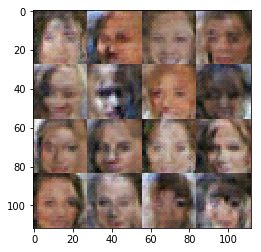

Step 1410... Discriminator Loss: 1.3719... Generator Loss: 0.8969
Step 1420... Discriminator Loss: 1.3705... Generator Loss: 0.7657
Step 1430... Discriminator Loss: 1.4718... Generator Loss: 0.4687
Step 1440... Discriminator Loss: 1.3179... Generator Loss: 0.7415
Step 1450... Discriminator Loss: 1.2929... Generator Loss: 0.7506
Step 1460... Discriminator Loss: 1.5183... Generator Loss: 0.9462
Step 1470... Discriminator Loss: 1.3505... Generator Loss: 0.7841
Step 1480... Discriminator Loss: 1.2615... Generator Loss: 0.8475
Step 1490... Discriminator Loss: 1.4325... Generator Loss: 0.8689
Step 1500... Discriminator Loss: 1.3865... Generator Loss: 0.5814


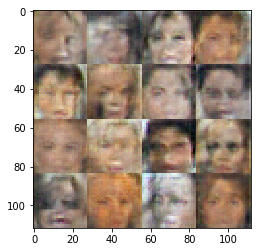

Step 1510... Discriminator Loss: 1.3209... Generator Loss: 0.9369
Step 1520... Discriminator Loss: 1.2867... Generator Loss: 0.7829
Step 1530... Discriminator Loss: 1.4138... Generator Loss: 1.0138
Step 1540... Discriminator Loss: 1.3631... Generator Loss: 0.7970
Step 1550... Discriminator Loss: 1.3596... Generator Loss: 0.6781
Step 1560... Discriminator Loss: 1.4686... Generator Loss: 0.7090
Step 1570... Discriminator Loss: 1.3612... Generator Loss: 0.8474
Step 1580... Discriminator Loss: 1.3692... Generator Loss: 0.5578
Step 1590... Discriminator Loss: 1.2450... Generator Loss: 0.8894
Step 1600... Discriminator Loss: 1.3040... Generator Loss: 0.8483


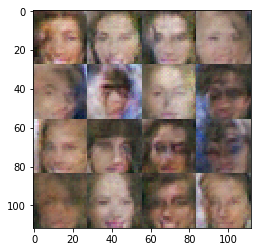

Step 1610... Discriminator Loss: 1.4559... Generator Loss: 0.6197
Step 1620... Discriminator Loss: 1.3886... Generator Loss: 0.8860
Step 1630... Discriminator Loss: 1.3313... Generator Loss: 0.7347
Step 1640... Discriminator Loss: 1.2802... Generator Loss: 0.7653
Step 1650... Discriminator Loss: 1.2790... Generator Loss: 0.7937
Step 1660... Discriminator Loss: 1.3238... Generator Loss: 0.6050
Step 1670... Discriminator Loss: 1.3156... Generator Loss: 0.7358
Step 1680... Discriminator Loss: 1.2878... Generator Loss: 0.6177
Step 1690... Discriminator Loss: 1.4766... Generator Loss: 0.6973
Step 1700... Discriminator Loss: 1.2295... Generator Loss: 0.6611


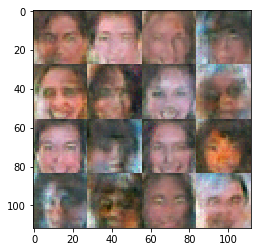

Step 1710... Discriminator Loss: 1.2857... Generator Loss: 0.6502
Step 1720... Discriminator Loss: 1.6033... Generator Loss: 0.4266
Step 1730... Discriminator Loss: 1.4715... Generator Loss: 0.5150
Step 1740... Discriminator Loss: 1.4009... Generator Loss: 0.8608
Step 1750... Discriminator Loss: 1.3254... Generator Loss: 0.8264
Step 1760... Discriminator Loss: 1.3447... Generator Loss: 0.5201
Step 1770... Discriminator Loss: 1.4529... Generator Loss: 0.7025
Step 1780... Discriminator Loss: 1.4388... Generator Loss: 0.9296
Step 1790... Discriminator Loss: 1.2384... Generator Loss: 0.8312
Step 1800... Discriminator Loss: 1.2459... Generator Loss: 0.8315


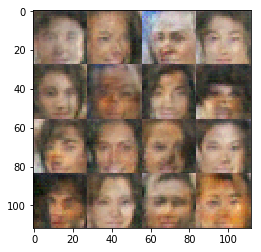

Step 1810... Discriminator Loss: 1.3057... Generator Loss: 0.6171
Step 1820... Discriminator Loss: 1.3172... Generator Loss: 0.8199
Step 1830... Discriminator Loss: 1.3199... Generator Loss: 0.7660
Step 1840... Discriminator Loss: 1.4685... Generator Loss: 0.9298
Step 1850... Discriminator Loss: 1.4532... Generator Loss: 0.7202
Step 1860... Discriminator Loss: 1.3953... Generator Loss: 0.8375
Step 1870... Discriminator Loss: 1.3629... Generator Loss: 0.8477
Step 1880... Discriminator Loss: 1.3055... Generator Loss: 0.6146
Step 1890... Discriminator Loss: 1.3093... Generator Loss: 0.8111
Step 1900... Discriminator Loss: 1.3589... Generator Loss: 0.8186


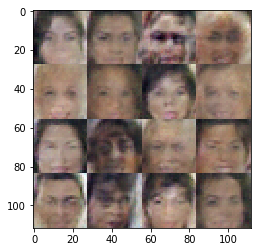

Step 1910... Discriminator Loss: 1.2422... Generator Loss: 0.5942
Step 1920... Discriminator Loss: 1.2900... Generator Loss: 0.7878
Step 1930... Discriminator Loss: 1.3503... Generator Loss: 0.9107
Step 1940... Discriminator Loss: 1.2249... Generator Loss: 0.8951
Step 1950... Discriminator Loss: 1.2674... Generator Loss: 0.8415
Step 1960... Discriminator Loss: 1.3324... Generator Loss: 0.6464
Step 1970... Discriminator Loss: 1.3032... Generator Loss: 0.7358
Step 1980... Discriminator Loss: 1.3389... Generator Loss: 0.8066
Step 1990... Discriminator Loss: 1.2394... Generator Loss: 0.8248
Step 2000... Discriminator Loss: 1.5314... Generator Loss: 0.6078


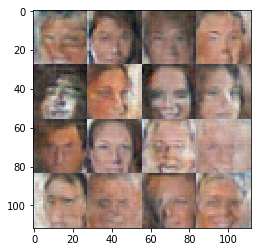

Step 2010... Discriminator Loss: 1.3524... Generator Loss: 0.7221
Step 2020... Discriminator Loss: 1.3095... Generator Loss: 0.8106
Step 2030... Discriminator Loss: 1.4326... Generator Loss: 0.6917
Step 2040... Discriminator Loss: 1.3441... Generator Loss: 1.0477
Step 2050... Discriminator Loss: 1.4003... Generator Loss: 0.9829
Step 2060... Discriminator Loss: 1.2889... Generator Loss: 0.7806
Step 2070... Discriminator Loss: 1.3005... Generator Loss: 0.8288
Step 2080... Discriminator Loss: 1.4388... Generator Loss: 0.8153
Step 2090... Discriminator Loss: 1.4571... Generator Loss: 0.6939
Step 2100... Discriminator Loss: 1.3772... Generator Loss: 0.8084


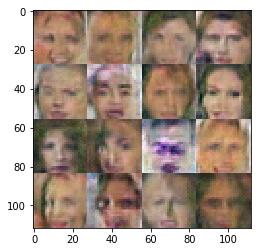

Step 2110... Discriminator Loss: 1.3428... Generator Loss: 0.8638
Step 2120... Discriminator Loss: 1.3114... Generator Loss: 0.8102
Step 2130... Discriminator Loss: 1.4568... Generator Loss: 0.5936
Step 2140... Discriminator Loss: 1.3215... Generator Loss: 0.6947
Step 2150... Discriminator Loss: 1.2527... Generator Loss: 0.9824
Step 2160... Discriminator Loss: 1.2865... Generator Loss: 0.8964
Step 2170... Discriminator Loss: 1.3542... Generator Loss: 0.8896
Step 2180... Discriminator Loss: 1.3058... Generator Loss: 0.9793
Step 2190... Discriminator Loss: 1.2235... Generator Loss: 0.7574
Step 2200... Discriminator Loss: 1.3574... Generator Loss: 0.5198


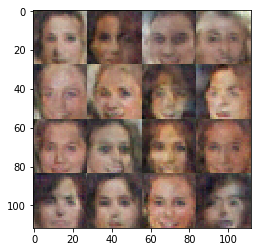

Step 2210... Discriminator Loss: 1.4929... Generator Loss: 0.4700
Step 2220... Discriminator Loss: 1.2612... Generator Loss: 0.8366
Step 2230... Discriminator Loss: 1.2143... Generator Loss: 0.8275
Step 2240... Discriminator Loss: 1.3197... Generator Loss: 0.9212
Step 2250... Discriminator Loss: 1.2907... Generator Loss: 0.6685
Step 2260... Discriminator Loss: 1.1806... Generator Loss: 0.7816
Step 2270... Discriminator Loss: 1.2503... Generator Loss: 0.5729
Step 2280... Discriminator Loss: 1.3657... Generator Loss: 1.0159
Step 2290... Discriminator Loss: 1.2657... Generator Loss: 0.9574
Step 2300... Discriminator Loss: 1.3549... Generator Loss: 0.8823


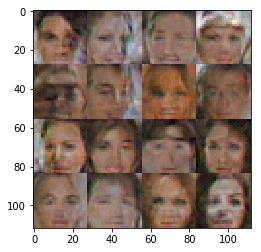

Step 2310... Discriminator Loss: 1.2741... Generator Loss: 0.7520
Step 2320... Discriminator Loss: 1.3466... Generator Loss: 0.6904
Step 2330... Discriminator Loss: 1.2816... Generator Loss: 0.6963
Step 2340... Discriminator Loss: 1.4283... Generator Loss: 0.8090
Step 2350... Discriminator Loss: 1.4586... Generator Loss: 0.8749
Step 2360... Discriminator Loss: 1.2009... Generator Loss: 0.9633
Step 2370... Discriminator Loss: 1.5179... Generator Loss: 1.0692
Step 2380... Discriminator Loss: 1.3829... Generator Loss: 0.5846
Step 2390... Discriminator Loss: 1.3739... Generator Loss: 0.9207
Step 2400... Discriminator Loss: 1.3488... Generator Loss: 1.0446


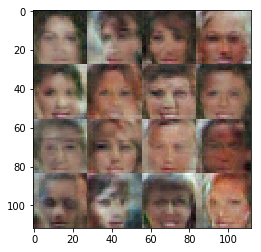

Step 2410... Discriminator Loss: 1.2615... Generator Loss: 0.7400
Step 2420... Discriminator Loss: 1.3535... Generator Loss: 0.7948
Step 2430... Discriminator Loss: 1.3372... Generator Loss: 0.6003
Step 2440... Discriminator Loss: 1.3733... Generator Loss: 0.9038
Step 2450... Discriminator Loss: 1.3138... Generator Loss: 1.1860
Step 2460... Discriminator Loss: 1.2759... Generator Loss: 0.9286
Step 2470... Discriminator Loss: 1.2935... Generator Loss: 0.8358
Step 2480... Discriminator Loss: 1.4540... Generator Loss: 0.9207
Step 2490... Discriminator Loss: 1.4885... Generator Loss: 0.5282
Step 2500... Discriminator Loss: 1.3124... Generator Loss: 0.7554


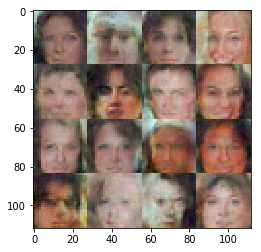

Step 2510... Discriminator Loss: 1.4021... Generator Loss: 0.5614
Step 2520... Discriminator Loss: 1.3663... Generator Loss: 0.6748
Step 2530... Discriminator Loss: 1.2786... Generator Loss: 0.8062
Step 2540... Discriminator Loss: 1.2763... Generator Loss: 0.6731
Step 2550... Discriminator Loss: 1.3103... Generator Loss: 0.8861
Step 2560... Discriminator Loss: 1.3169... Generator Loss: 0.6580
Step 2570... Discriminator Loss: 1.3351... Generator Loss: 0.8980
Step 2580... Discriminator Loss: 1.2355... Generator Loss: 0.8556
Step 2590... Discriminator Loss: 1.3317... Generator Loss: 0.8921
Step 2600... Discriminator Loss: 1.1786... Generator Loss: 1.0432


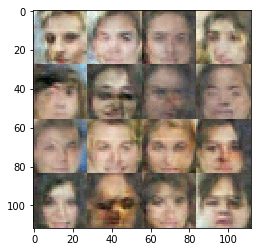

Step 2610... Discriminator Loss: 1.4631... Generator Loss: 1.0813
Step 2620... Discriminator Loss: 1.3132... Generator Loss: 0.8019
Step 2630... Discriminator Loss: 1.4721... Generator Loss: 0.5098
Step 2640... Discriminator Loss: 1.3163... Generator Loss: 0.7681
Step 2650... Discriminator Loss: 1.3556... Generator Loss: 0.8725
Step 2660... Discriminator Loss: 1.3101... Generator Loss: 0.7352
Step 2670... Discriminator Loss: 1.4778... Generator Loss: 0.9001
Step 2680... Discriminator Loss: 1.2642... Generator Loss: 0.8191
Step 2690... Discriminator Loss: 1.3500... Generator Loss: 0.9109
Step 2700... Discriminator Loss: 1.1475... Generator Loss: 0.6246


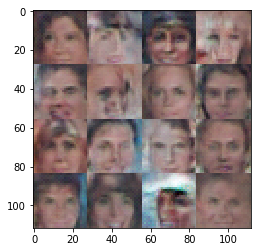

Step 2710... Discriminator Loss: 1.4168... Generator Loss: 0.9414
Step 2720... Discriminator Loss: 1.2213... Generator Loss: 0.8527
Step 2730... Discriminator Loss: 1.2891... Generator Loss: 1.0382
Step 2740... Discriminator Loss: 1.3526... Generator Loss: 0.6148
Step 2750... Discriminator Loss: 1.2092... Generator Loss: 0.7471
Step 2760... Discriminator Loss: 1.3644... Generator Loss: 1.0185
Step 2770... Discriminator Loss: 1.2959... Generator Loss: 0.6063
Step 2780... Discriminator Loss: 1.3377... Generator Loss: 0.9082
Step 2790... Discriminator Loss: 1.2974... Generator Loss: 0.7514
Step 2800... Discriminator Loss: 1.4272... Generator Loss: 0.6373


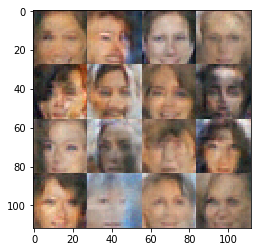

Step 2810... Discriminator Loss: 1.3016... Generator Loss: 0.9109
Step 2820... Discriminator Loss: 1.2290... Generator Loss: 0.6394
Step 2830... Discriminator Loss: 1.4867... Generator Loss: 1.0694
Step 2840... Discriminator Loss: 1.2419... Generator Loss: 0.9647
Step 2850... Discriminator Loss: 1.2299... Generator Loss: 0.7630
Step 2860... Discriminator Loss: 1.3090... Generator Loss: 0.7667
Step 2870... Discriminator Loss: 1.2570... Generator Loss: 0.7311
Step 2880... Discriminator Loss: 1.2469... Generator Loss: 0.8003
Step 2890... Discriminator Loss: 1.1793... Generator Loss: 0.6472
Step 2900... Discriminator Loss: 1.3608... Generator Loss: 0.7951


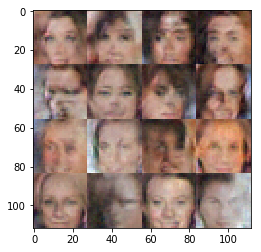

Step 2910... Discriminator Loss: 1.3699... Generator Loss: 0.7171
Step 2920... Discriminator Loss: 1.3254... Generator Loss: 1.1381
Step 2930... Discriminator Loss: 1.2460... Generator Loss: 0.8286
Step 2940... Discriminator Loss: 1.3057... Generator Loss: 0.7107
Step 2950... Discriminator Loss: 1.2838... Generator Loss: 0.9142
Step 2960... Discriminator Loss: 1.3272... Generator Loss: 0.6763
Step 2970... Discriminator Loss: 1.1866... Generator Loss: 0.9023
Step 2980... Discriminator Loss: 1.3352... Generator Loss: 0.8174
Step 2990... Discriminator Loss: 1.3388... Generator Loss: 0.7636
Step 3000... Discriminator Loss: 1.1532... Generator Loss: 1.1039


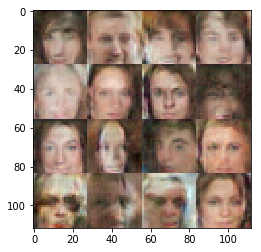

Step 3010... Discriminator Loss: 1.2543... Generator Loss: 1.0265
Step 3020... Discriminator Loss: 1.3188... Generator Loss: 0.7212
Step 3030... Discriminator Loss: 1.3526... Generator Loss: 0.9790
Step 3040... Discriminator Loss: 1.2973... Generator Loss: 1.0443
Step 3050... Discriminator Loss: 1.2624... Generator Loss: 0.9274
Step 3060... Discriminator Loss: 1.2813... Generator Loss: 0.6831
Step 3070... Discriminator Loss: 1.2808... Generator Loss: 0.8386
Step 3080... Discriminator Loss: 1.3154... Generator Loss: 0.7923
Step 3090... Discriminator Loss: 1.2183... Generator Loss: 0.9294
Step 3100... Discriminator Loss: 1.2111... Generator Loss: 0.9007


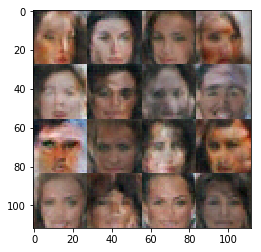

Step 3110... Discriminator Loss: 1.2640... Generator Loss: 0.8768
Step 3120... Discriminator Loss: 1.2936... Generator Loss: 0.8711
Step 3130... Discriminator Loss: 1.2846... Generator Loss: 0.8195
Step 3140... Discriminator Loss: 1.3157... Generator Loss: 0.7306
Step 3150... Discriminator Loss: 1.1536... Generator Loss: 0.9271
Step 3160... Discriminator Loss: 1.1842... Generator Loss: 0.9253


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.